<a href="https://colab.research.google.com/github/reetika-goel/Emerging-Technologies/blob/master/Dog_Breed_Classifier(V2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Assignment 3***

# **Dog Breed Classification**

Submission By: **Reetika Goel**

In this notebook, I am building a model to identify dog breeds in an image. I will use the **Kaggle's Dog Breed Dataset** dataset for training. It has 120 breeds of dogs.

The training set has total of 10222 images across these 120 breeds. There are total 3 files provided in thid dataset:

- *Train.zip* has 10222 images of dogs. Each image has a unique file name which acts as an id of the image.
- *Test.zip* has total 10357 images of dogs. But we don't have the breed name of these images. Once we have trained the model, we have to pedict the breed of dogs in these images.
- *labels.csv* has breed label for all the training images.

References -
- https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41
- https://keras.io/applications/#usage-examples-for-image-classification-models
- https://www.kaggle.com/gaborfodor/dog-breed-pretrained-keras-models-lb-0-3
- https://www.kaggle.com/c/dog-breed-identification
- https://towardsdatascience.com/dog-breed-prediction-using-cnns-and-transfer-learning-22d8ed0b16c5
- https://medium.com/nanonets/how-to-easily-build-a-dog-breed-image-classification-model-2fd214419cde

In [28]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# **Import Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

import datetime as dt
import tensorflow as tf
tf.__version__
import os
from keras.preprocessing import image
# from keras.applications.inception_v3 import preprocess_input, InceptionV3, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.applications.xception import preprocess_input, Xception, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import pickle

%matplotlib inline


Using TensorFlow backend.


### **Configuring Keras on TPUs in Colab**

In [3]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.5.87.50:8470


**Initialize variables**

In [0]:
DEBUG = False
# recommended input size for inception architecture
INPUT_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_OF_CLASSES = 120 if(not DEBUG) else 4
TRAIN_IMAGE_DIR = '/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/train/'

## **Analyse Data**

In [5]:
labels_filename = '/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/labels.csv'
labels_data = pd.read_csv(labels_filename, delimiter=",")
breed_size = labels_data.groupby("breed").size()
print(breed_size.values)
print("max {}, min {}, mean {}".format(breed_size.max(), breed_size.min(),breed_size.mean()))

[ 80 116  86 107  74  78 102 110  82 105  89 114  77 102  85  85  72  91
  75  87  86  75  67  66  73  75 106  76  83  71  93  80  74  87  72  89
  76  80  74  86  83  75 115  66  72  70  69  75  69  67  81  75 111  82
  82  91  88  82  78 101  92 105  81  86  82  67  71  84  99 106  90  81
  73 117  80 102  79  78  91  83  95  78  87  69  96  75  92 111  94  72
  88  76  84  99 109  86  82 126  88  76 112  95  90  71  79  79  72  78
  69 107  80  79  70  69  85  79  81  95  82  82]
max 126, min 66, mean 85.18333333333334


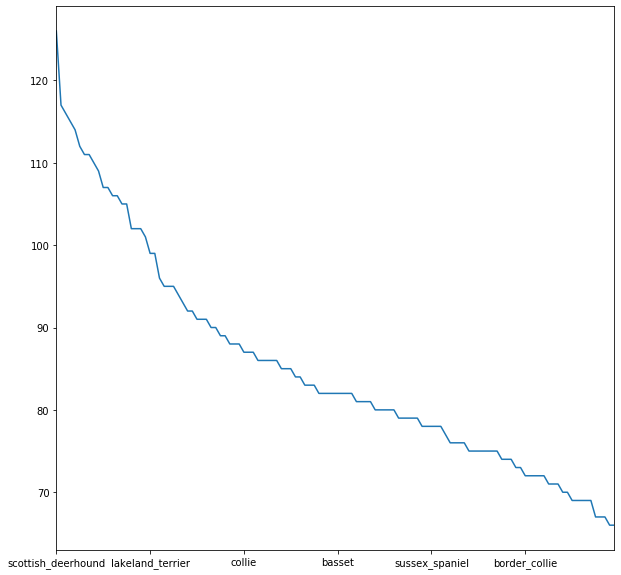

In [6]:
plt.figure(figsize=(10,10))
labels_data['breed'].value_counts().plot.line()

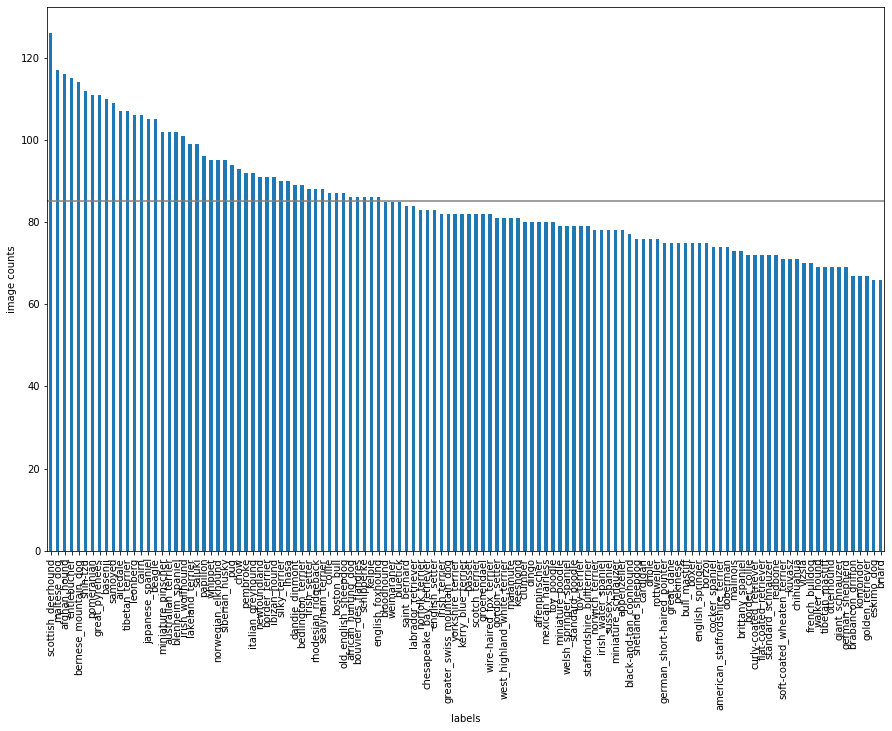

In [7]:
plt.figure(figsize=(15,10))
plt.axhline(breed_size.mean(), color="gray")
plt.xlabel("labels")
plt.ylabel("image counts")
labels_data['breed'].value_counts().plot.bar()

From above, it is clear that minimum number of training data for a breed is 66 images. None of the breed has a very large training set. on average a breed has 85 images. This is a very small dataset for training a convolution neural net from scratch. We would get much better result by using a pretrained model for this problem.

In [8]:
label_classes = labels_data.breed.unique()
label_classes.sort()
print(label_classes)

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'italian

## **Display Some Images with Breeds**

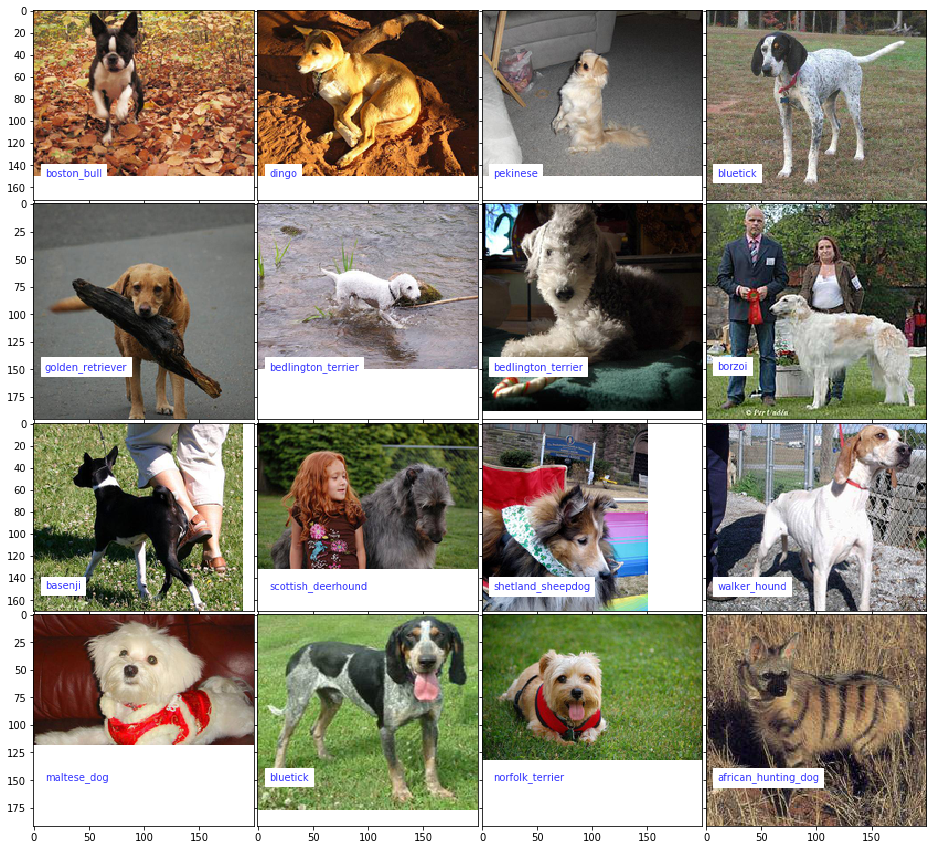

In [9]:
total_records = len(labels_data.id)
# print(idx_arr)

rows = 4
cols = 4
idx_arr = np.ceil(np.random.random((rows * cols)) * total_records)
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.05)

for i, idx in enumerate(idx_arr):
    col = i % cols
    row = i // rows
    title = labels_data.breed[i]
#     print(TRAIN_IMAGE_DIR + labels_data.id[i] + ".jpg")
#     image = plt.imread(TRAIN_IMAGE_DIR + labels_data.id[i] + ".jpg")
    img = Image.open(TRAIN_IMAGE_DIR + labels_data.id[i] + ".jpg")
    img.thumbnail((200, 200), Image.ANTIALIAS)
    grid[i].imshow(img)
    grid[i].text(10, 150, title, color='b', backgroundcolor='w', alpha=0.8 )
plt.show()

The above images are taken randomly from the training set to demonstrate the nature of images. Below are the observations:
- The resolution of images is not same.
- Aspect ratio of images is also different for different images.
- Some images have other people along with the dog.
- Some has image of dog with wooden piece in mouth.
- In some images, dogs are wearing leash or some cloth.

Dogs are not always in the centre of image so we can't crop the images. It would be difficult to train a model with varying number of inputs. To avoid this, I will resize all the images to one common size before feeding to the model.

## **Choose Smaller set for Debug**

In [10]:
if(DEBUG==True):
#   take biggest set of data for few breeds
    labels_group_size = labels_data.groupby('breed').size().sort_values(ascending=False)
    print(labels_group_size)                         
    selected_breed_list = list(labels_group_size.head(NUM_OF_CLASSES).index)
    print("selected breeds for debugging ", str(selected_breed_list))
    labels = labels_data[labels_data['breed'].isin(selected_breed_list)]
else:
    labels = labels_data
print("shape of labels", labels.shape)

shape of labels (10222, 2)


# **Data Augmentation**
We use data augmentation to artificially increase the number of training images. We do this by manipulating (scaling, zooming, rotating, etc.) the input images.
Here is an example of what data augmentation does

In [0]:
def data_augmentation_example(input_path, count):
    # load image to array
    image = img_to_array(load_img(input_path))

    # reshape to array rank 4
    image = image.reshape((1,) + image.shape)

    # let's create infinite flow of images
    train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
    images_flow = train_datagen.flow(image, batch_size=1)

    plt.figure(figsize=(9,9))
    for idx, new_images in enumerate(images_flow):
        if idx < count:
            plt.subplot(330 + 1 + idx)
            new_image = array_to_img(new_images[0], scale=True)
            plt.imshow(new_image)
            plt.axis('off')
        else:
            plt.show()
            break

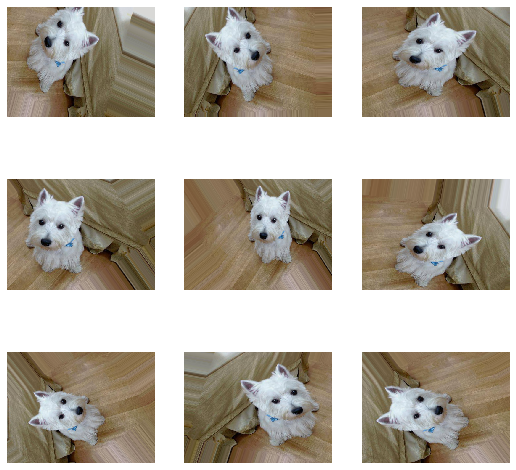

In [12]:
input_path = '/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/train/0a27d304c96918d440e79e6e9e245c3f.jpg'
#00a338a92e4e7bf543340dc849230e75.jpg' # An example image from the dataset
count = 9 # Number of samples to show

data_augmentation_example(input_path, count)

# **Split into Train and Validation set**

- Split the data into 80% train data and 20% validation data.

In [13]:
train_labels, val_labels = train_test_split(labels, test_size=0.2, random_state=42)
print(train_labels.shape)
print(val_labels.shape)

(8177, 2)
(2045, 2)


## **Load the images into an array and preprocess for feeding to model**

In [0]:
def load_preprocess_image(image_id, size, filedir):
    filename = filedir + image_id + ".jpg"
    img = image.load_img(filename, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

## **Predict using Keras Xception model**

In [0]:
def predictions_xception(y_train, model, batch_size, filedir):
    # process 32 images at a time to keep the memory usage low
    # initialize x train, x_val to the required size 
    iterations = int(np.ceil(len(y_train)/BATCH_SIZE))
    predict_train = np.zeros((len(y_train), 2048), dtype=float)

    for idx in range(iterations):
        iteration_size = BATCH_SIZE if (idx<iterations-1) else (len(y_train) - idx * BATCH_SIZE)
        x_train = np.zeros((iteration_size, INPUT_SIZE[0], INPUT_SIZE[1], 3), dtype=float)
        start_idx = idx * BATCH_SIZE
        end_idx = start_idx + iteration_size

        for idx1, image_id in enumerate(y_train[start_idx:end_idx]):
            x_train[idx1] = load_preprocess_image(image_id, INPUT_SIZE, filedir)

        predict_train[start_idx:end_idx] = model.predict(x_train, verbose=1)
    return predict_train

In [16]:
y_train = train_labels['id']
y_val = val_labels['id']
model = Xception(weights='imagenet', include_top=False, pooling='avg')

predict_train = predictions_xception(y_train, model, BATCH_SIZE, '/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/train/')
predict_val = predictions_xception(y_val, model, BATCH_SIZE, '/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/train/')

print(predict_train.shape)
print(predict_val.shape)
print(predict_train.size)
print(predict_val.size)













29/29 [==============================] - 19s 640ms/step
(8177, 2048)
(2045, 2048)
16746496
4188160


In [17]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

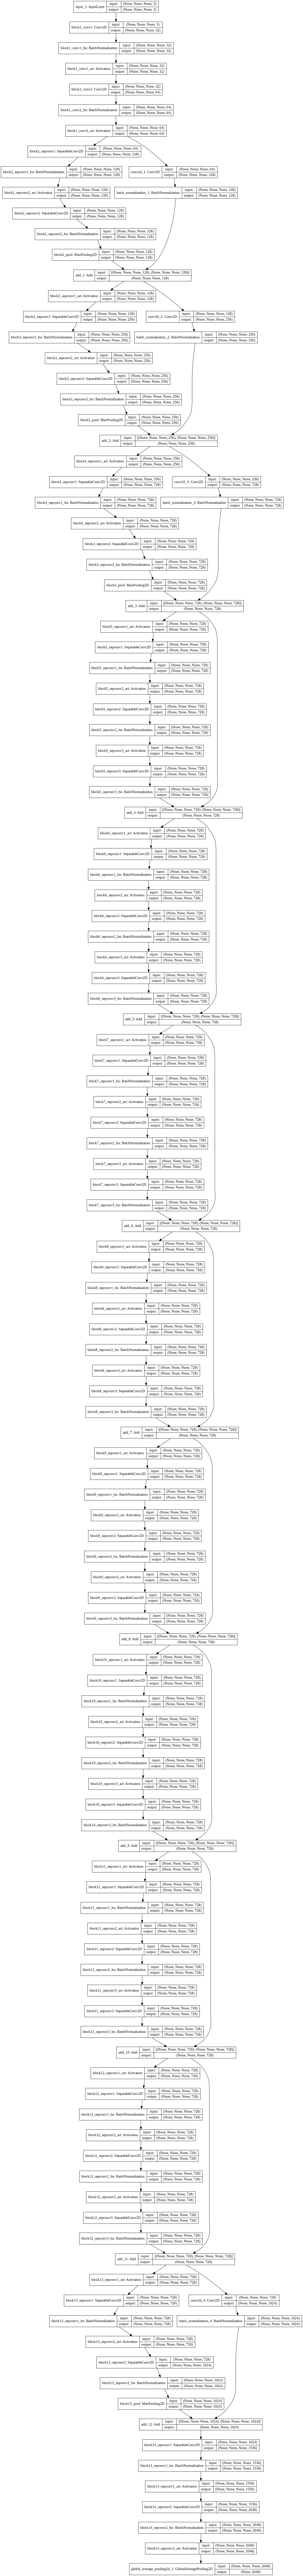

In [18]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='Xception.png')

### **Checkpoint1 - Save Xception predictions**

In [0]:
# save predictions in file
predict_train_file = 'checkpoint_1.pickle'
params_cp1 = {"predict_train":predict_train, "predict_val":predict_val, "train_labels":train_labels}
with open(predict_train_file, 'wb') as handle:
    pickle.dump(params_cp1, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_checkpoint1():
    with open(predict_train_file, 'rb') as handle:
        load_cp1 = pickle.load(handle)
        predict_train = load_cp1['predict_train']
        predict_val = load_cp1['predict_val']
        train_labels = load_cp1['train_labels']

# print(params['predict_train'] == b['predict_train'])
# print(params['predict_val'] == b['predict_val'])

### **Load Checkpoint1**
uncomment below and execute cell to load checkpoint 1 data

In [0]:
# load_checkpoint1()

### **Train Logistics Regression on Xception output**

In [21]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logreg.fit(predict_train, train_labels['breed'])
valid_probs = logreg.predict_proba(predict_val)
valid_preds = logreg.predict(predict_val)
print(valid_preds)
print(val_labels['breed'].values)
print('train Xception LogLoss {}'.format(log_loss(train_labels['breed'], logreg.predict_proba(predict_train))))
print('train Xception Accuracy {}'.format(accuracy_score((train_labels['breed'].values), logreg.predict(predict_train))))
print('Validation Xception LogLoss {}'.format(log_loss(val_labels['breed'], valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((val_labels['breed'].values), valid_preds)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['toy_terrier' 'irish_setter' 'scottish_deerhound' ... 'irish_setter'
 'golden_retriever' 'labrador_retriever']
['toy_terrier' 'irish_setter' 'scottish_deerhound' ... 'irish_setter'
 'golden_retriever' 'labrador_retriever']
train Xception LogLoss 0.044454139626238454
train Xception Accuracy 0.998777057600587
Validation Xception LogLoss 0.3349354051446262
Validation Xception Accuracy 0.8982885085574572


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


['toy_terrier' 'irish_setter' 'scottish_deerhound' ... 'irish_setter'
 'golden_retriever' 'labrador_retriever']
['toy_terrier' 'irish_setter' 'scottish_deerhound' ... 'irish_setter'
 'golden_retriever' 'labrador_retriever']
train Xception LogLoss 0.044454139626238454
train Xception Accuracy 0.998777057600587
Validation Xception LogLoss 0.3349354051446262
Validation Xception Accuracy 0.8982885085574572


- **Accuracy of our Xception + Logistic Regression model for validation dataset is 89.9 % and loss score is 0.3348.**

### **Execute model for Test data**

In [0]:
# predictions for test data
# get list of filenames/ids

def get_file_ids(dir):
    ids = [f[:-4] for f in os.listdir(dir) if f.endswith('.jpg')]
    return ids

In [23]:
y_test = get_file_ids("/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/test/")
predict_test_Xception = predictions_xception(y_test, model, BATCH_SIZE, "/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/test/")
test_probs = logreg.predict_proba(predict_test_Xception)
test_preds = logreg.predict(predict_test_Xception)
# print(test_probs.shape)
# print(test_preds.sh)

21/21 [==============================] - 13s 630ms/step


In [0]:
result_file = "/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/sample_submission.csv"

df2 = pd.DataFrame(test_probs, columns=label_classes, index=y_test )
df2.to_csv(result_file, sep=",", float_format="%1.17f", index_label="id")

## **Validate images from third source**

In [25]:
labels_outside = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/free-form/labels.csv', delimiter=",")
print(labels_outside)
y_outside = get_file_ids("/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/free-form/images/")
predict_outside_Xception = predictions_xception(y_outside, model, BATCH_SIZE, "/content/drive/My Drive/Colab Notebooks/Dog_breed_Classifier/free-form/images/")
outside_probs = logreg.predict_proba(predict_outside_Xception)
outside_preds = logreg.predict(predict_outside_Xception)

df_outside = pd.DataFrame(outside_probs, columns=label_classes, index=y_outside)

# label, top 3 pred + prob

   id               breed
0   1  scottish_deerhound
1   2              briard
2   3              briard
3   4              briard
4   5       gordon_setter
5   6         appenzeller
6   7            leonberg
7   8            leonberg
   id               breed
0   1  scottish_deerhound
1   2              briard
2   3              briard
3   4              briard
4   5       gordon_setter
5   6         appenzeller
6   7            leonberg
7   8            leonberg
8/8 [==============================] - 5s 621ms/step


In [26]:
for i, x in enumerate(outside_preds):
    print (outside_preds[i])
    print(df_outside[x][i])

leonberg
0.9908089282420658
briard
0.7747591508318723
leonberg
0.9960108897695628
scottish_deerhound
0.9964379459133469
entlebucher
0.9566647403272345
gordon_setter
0.9257779793949835
briard
0.9550837502429212
briard
0.9840740591877342
leonberg
0.9908089282420658
briard
0.7747591508318723
leonberg
0.9960108897695628
scottish_deerhound
0.9964379459133469
entlebucher
0.9566647403272345
gordon_setter
0.9257779793949835
briard
0.9550837502429212
briard
0.9840740591877342
